## Perform analysis on CheXNet train, val, test split and remove bad sample from the data

In [1]:
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import math
import numpy as np

In [2]:
CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural Thickening', 'Hernia']

## 1. Check CheXNet train, val, test split

In [3]:
def get_id(row):
    return row.split('_')[0].lstrip('0')

In [4]:
strong_df = pd.read_csv('BBox_List_2017.csv')
strong_patient_ids = set(strong_df['Image Index'].apply(get_id).values)
print('Strong patient', len(strong_patient_ids))

Strong patient 726


In [5]:
chexnet_train_df = pd.read_csv('chexnet_train_list.csv', header=None, delimiter=' ')
chexnet_val_df = pd.read_csv('chexnet_val_list.csv', header=None, delimiter=' ')
chexnet_test_df = pd.read_csv('chexnet_test_list.csv', header=None, delimiter=' ')
nih_train_val_df = pd.read_csv('nih_train_val_list.csv', header=None)
nih_test_df = pd.read_csv('nih_test_list.csv', header=None)

chexnet_train_patients_ids = set(chexnet_train_df.iloc[:, 0].apply(get_id).values)
chexnet_val_patients_ids = set(chexnet_val_df.iloc[:, 0].apply(get_id).values)
chexnet_test_patients_ids = set(chexnet_test_df.iloc[:, 0].apply(get_id).values)
nih_train_val_patients_ids = set(nih_train_val_df.iloc[:, 0].apply(get_id).values)
nih_test_patients_ids = set(nih_test_df.iloc[:, 0].apply(get_id).values)

In [7]:
print(f'Chexnet Train: #Image: {len(chexnet_train_df)}, #Patients: {len(chexnet_train_patients_ids)}')
print(f'Chexnet Val: #Image: {len(chexnet_val_df)}, #Patients: {len(chexnet_val_patients_ids)}')
print(f'Chexnet Test: #Image: {len(chexnet_test_df)}, #Patients: {len(chexnet_test_patients_ids)}')
print()
print(f'NIH Train Val: #Image: {len(nih_train_val_df)}, #Patients: {len(nih_train_val_patients_ids)}')
print(f'NIH Test: #Image: {len(nih_test_df)}, #Patients: {len(nih_test_patients_ids)}')

Chexnet Train: #Image: 78468, #Patients: 21528
Chexnet Val: #Image: 11219, #Patients: 3090
Chexnet Test: #Image: 22433, #Patients: 6187

NIH Train Val: #Image: 86524, #Patients: 28008
NIH Test: #Image: 25596, #Patients: 2797


### Check strong label in train, test, val ChexNet

In [8]:
# Check if strong label in train 
print('Train patient', len(chexnet_train_patients_ids))
chexnet_strong_train_intersect_ids = chexnet_train_patients_ids.intersection(strong_patient_ids)
print('Interect with strong label', len(chexnet_strong_train_intersect_ids))

Train patient 21528
Interect with strong label 511


In [9]:
# check if strong label in val
print('Val patient', len(chexnet_val_patients_ids))
chexnet_strong_val_intersect_ids = chexnet_val_patients_ids.intersection(strong_patient_ids)
print('Interect with strong label', len(chexnet_strong_val_intersect_ids))

Val patient 3090
Interect with strong label 67


In [10]:
# check if strong label in test
print('test patient', len(chexnet_test_patients_ids))
chexnet_strong_test_intersect_ids = chexnet_test_patients_ids.intersection(strong_patient_ids)
print('Interect with strong label', len(chexnet_strong_test_intersect_ids))

test patient 6187
Interect with strong label 148


In [11]:
# The strong label is spread accross train, val and test set
len(chexnet_strong_train_intersect_ids) + len(chexnet_strong_test_intersect_ids) + len(chexnet_strong_val_intersect_ids) == len(strong_patient_ids)

True

### Check strong label in train, test, val NIH

In [17]:
# Check if strong label in train, val
print('Train patient', len(nih_train_val_patients_ids))
nih_strong_train_intersect_ids = nih_train_val_patients_ids.intersection(strong_patient_ids)
print('Interect with strong label', len(nih_strong_train_intersect_ids))

Train patient 28008
Interect with strong label 0


In [18]:
# check if strong label in test
print('test patient', len(nih_test_patients_ids))
nih_strong_test_intersect_ids = nih_test_patients_ids.intersection(strong_patient_ids)
print('Interect with strong label', len(nih_strong_test_intersect_ids))

test patient 2797
Interect with strong label 726


In [19]:
# The strong label is spread accross train, val and test set
len(nih_strong_train_intersect_ids) + len(nih_strong_test_intersect_ids) == len(strong_patient_ids)

True

# => Decided to use original NIH split

### Check overlap between train val, test

In [20]:
# check overlap between patient id in train and val
intersect_ids = nih_train_val_patients_ids.intersection(nih_test_patients_ids)
print('Overlap', len(intersect_ids))

Overlap 0


### Is chexnet split is originated from nih?

In [23]:
nih_chexnet_test_intersect = nih_test_patient_ids.intersection(chexnet_test_patients_ids)
print('Overlap', len(nih_chexnet_test_intersect))

Overlap 590


**=> The answer is no**

## 2. Visualize bad data and remove it from train, val, test split

In [24]:
base_dir = '/mnt/data/xray-thesis/data/chestX-ray14/'
def plot_batch(image_names, title, n=24):
    cols = 6
    image_names = shuffle(image_names)
    n = min(len(image_names), n)
    rows = math.floor(n/cols)
    plt.figure(figsize=(24, 4*rows))
    plt.suptitle(title, size=20)
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        image_file = base_dir + image_names[i]
        imshow(image_file)

def imshow(file):
    plt.imshow(Image.open(file).convert('RGB'))
    plt.xticks([])
    plt.yticks([])

#### Rotated image

18

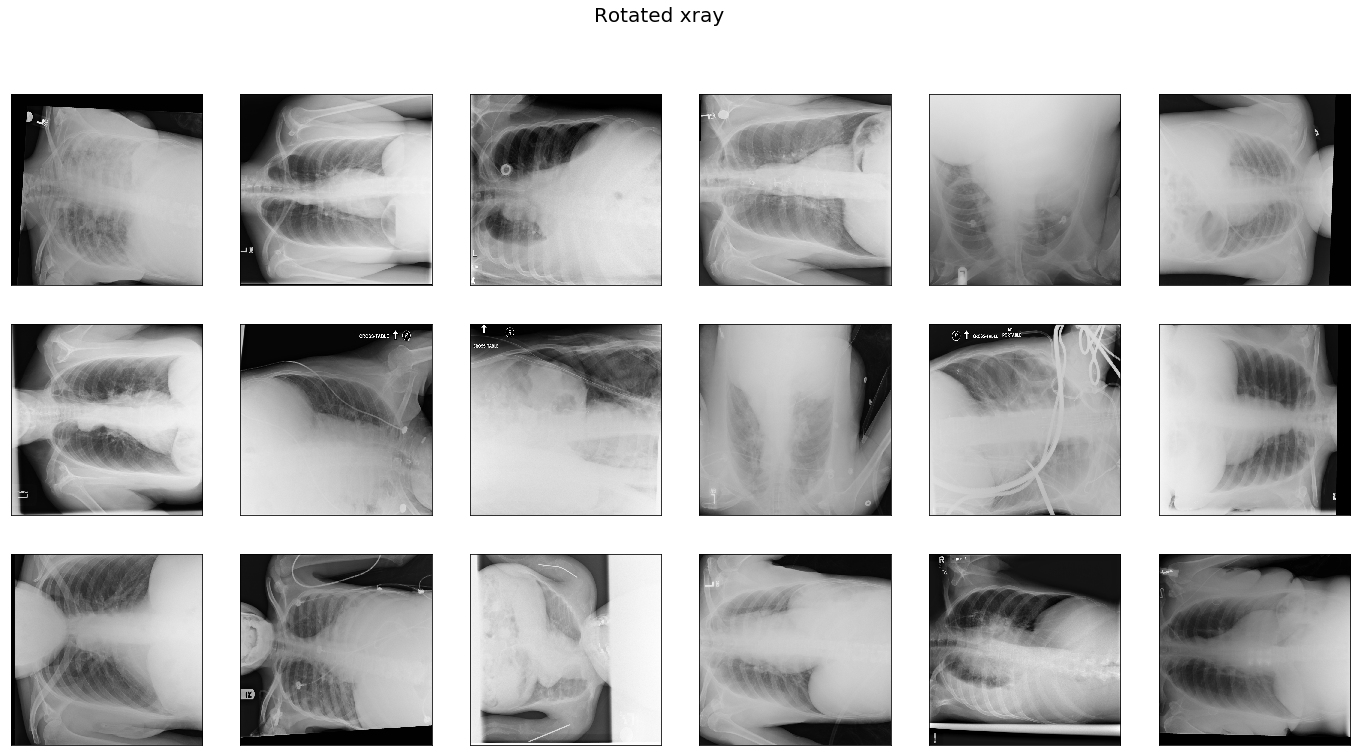

In [25]:
azure_rotated = pd.read_csv('blacklist_rotated_images.csv', header=None)
azure_rotated = azure_rotated.values.squeeze()
plot_batch(azure_rotated, 'Rotated xray')
azure_rotated.size

#### Side Xray with no frontal view

56

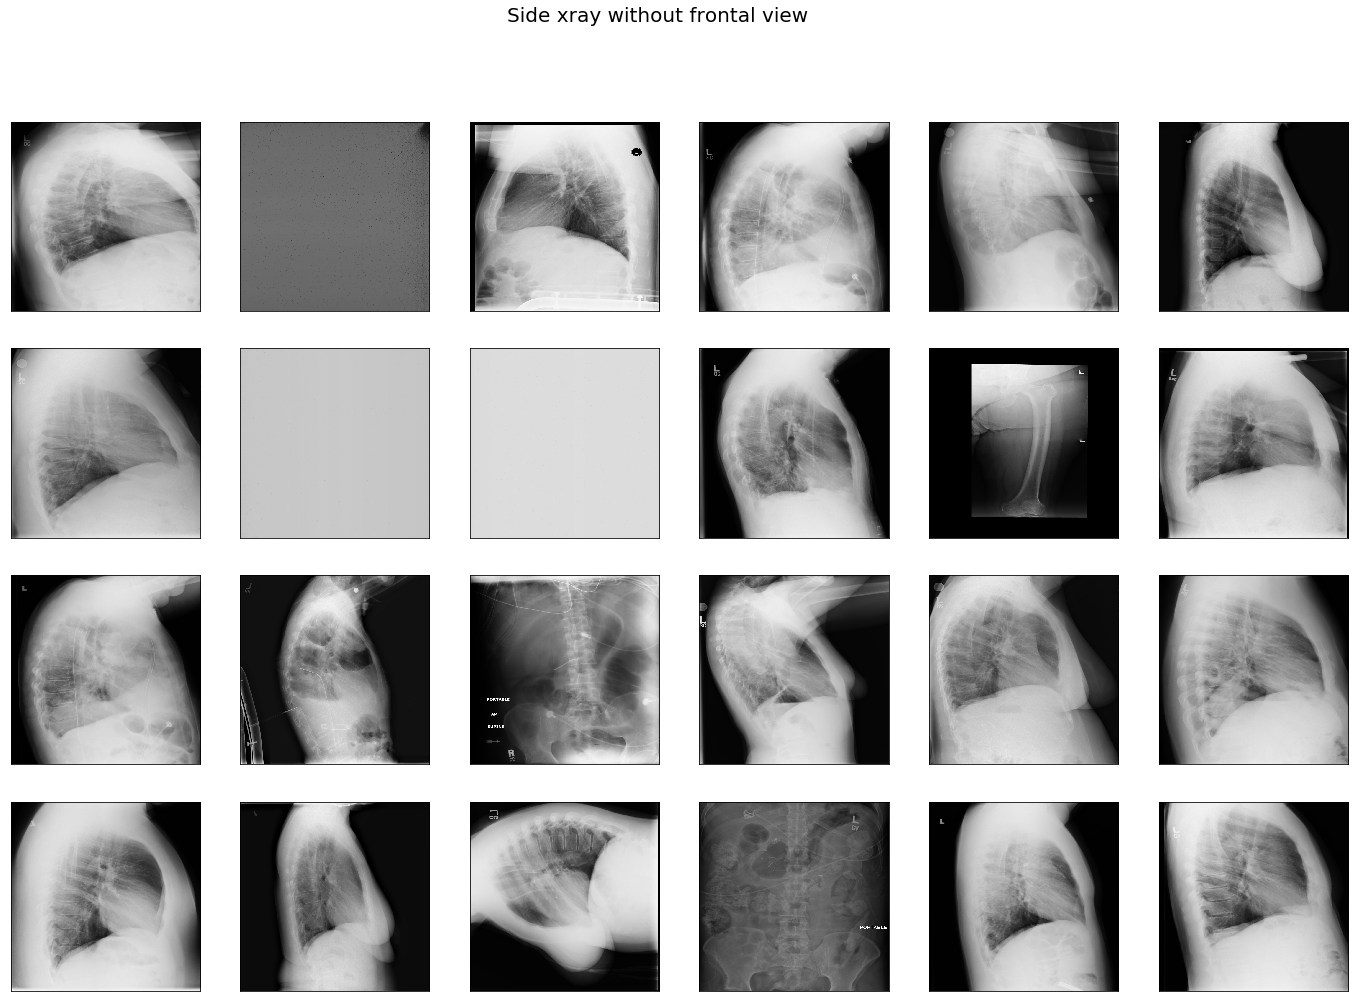

In [27]:
azure_nonPA = pd.read_csv('blacklist_non_PA_AP_view.csv', header=None)
azure_nonPA = azure_nonPA.values.squeeze()
plot_batch(azure_nonPA, 'Side xray without frontal view')
azure_nonPA.size

#### Low quality

1094

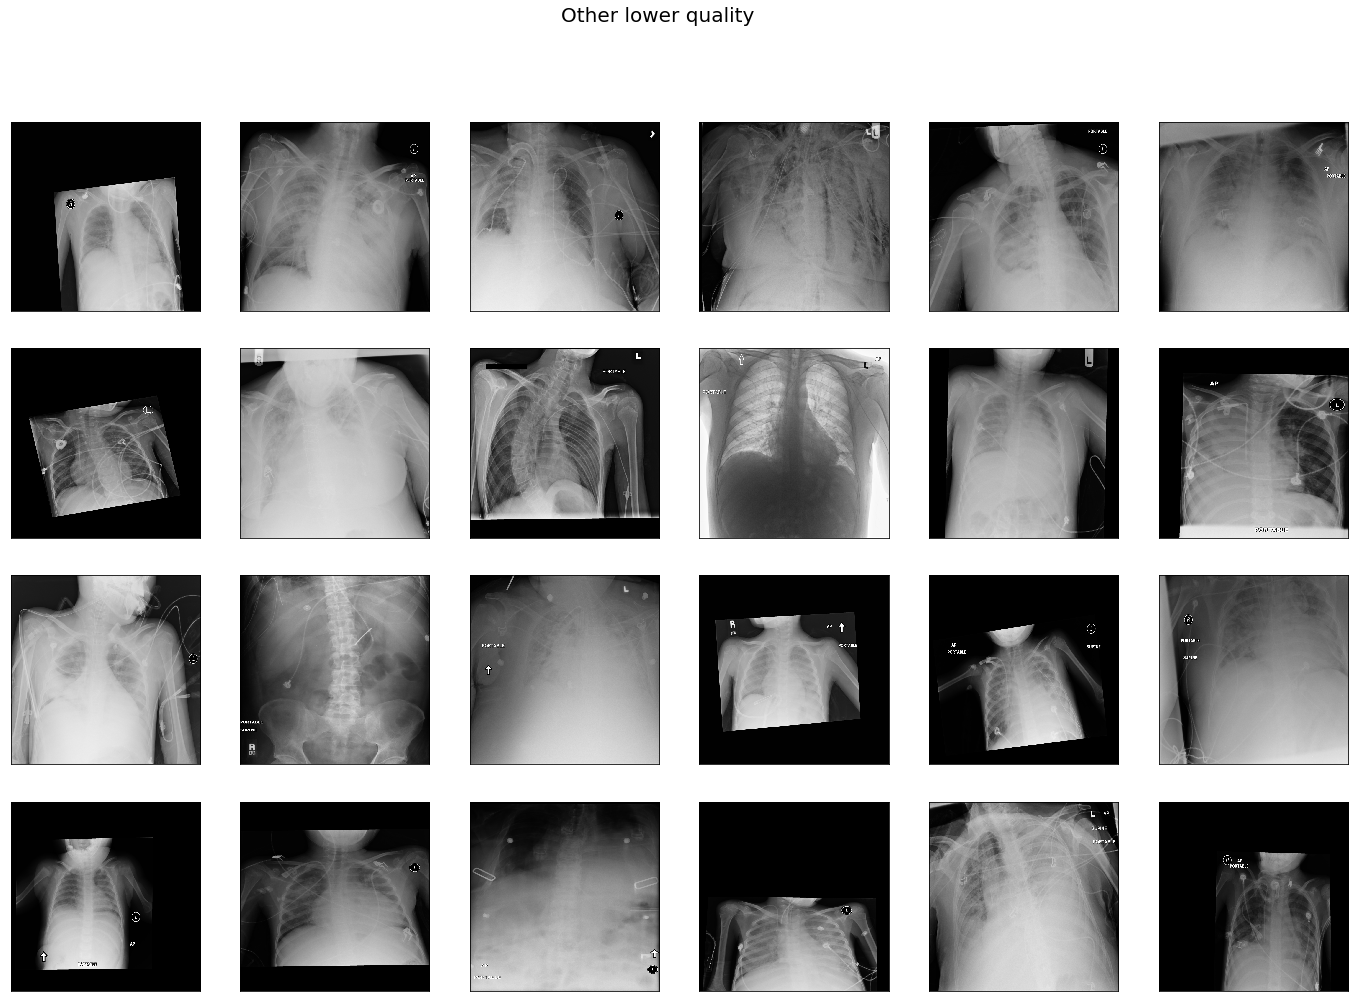

In [28]:
azure_low_quality = pd.read_csv('blacklist_other_images_with_lower_quality.csv', header=None)
azure_low_quality = azure_low_quality.values.squeeze()
plot_batch(azure_low_quality, 'Other lower quality')
azure_low_quality.size

#### Age < 10

1425

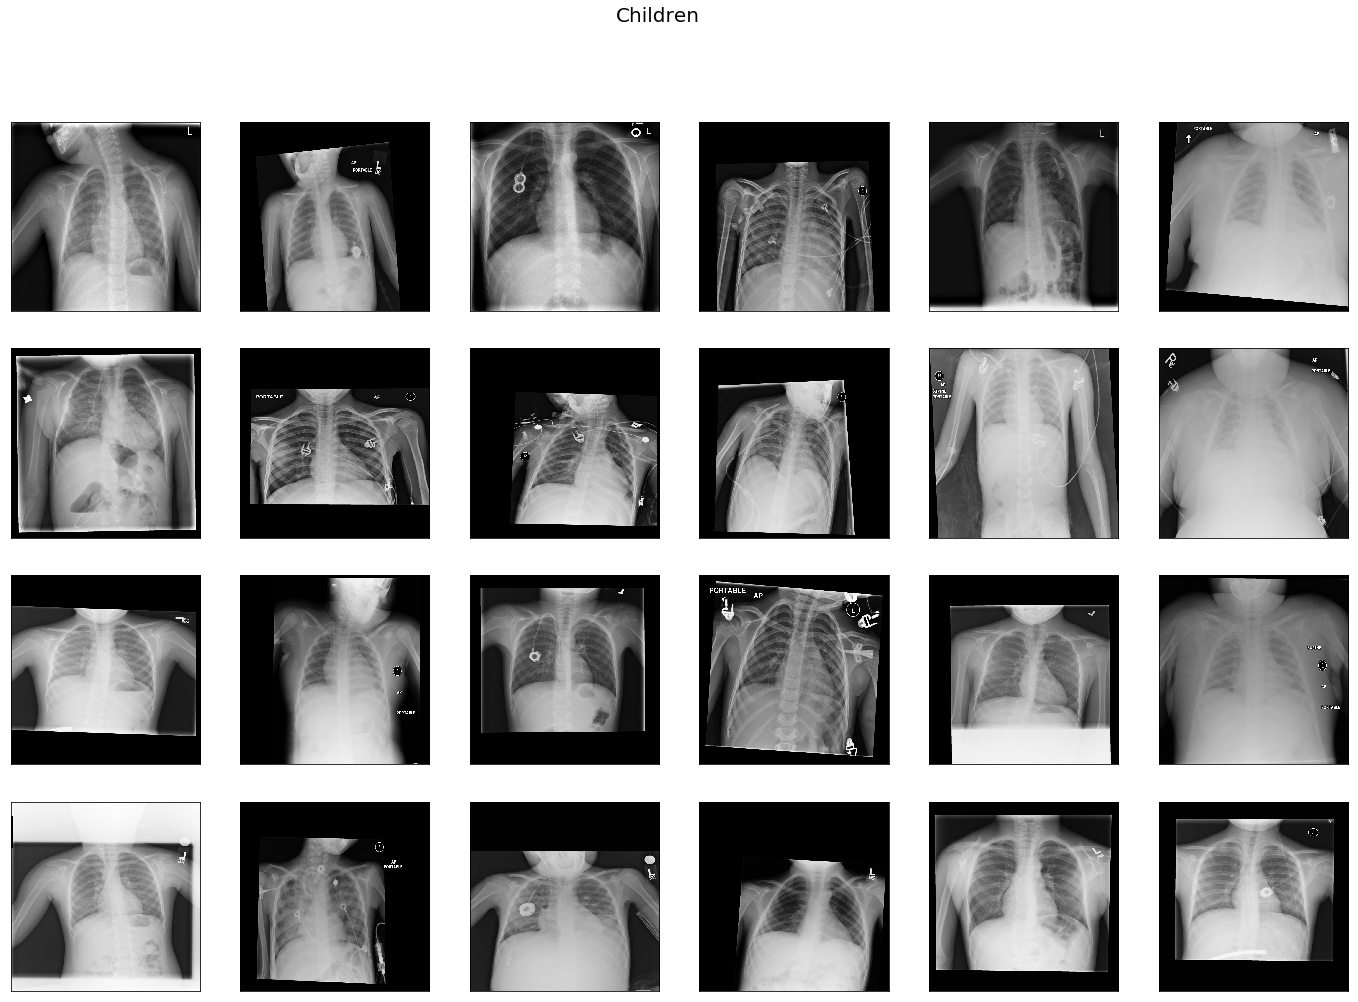

In [34]:
df = pd.read_csv('Data_Entry_Clean.csv')
age_below_10 = df[df.Age < 10]['Image Index'].values
plot_batch(age_below_10, 'Children')
age_below_10.size

In [29]:
luke_df = pd.read_csv('cxr14_bad_labels.csv')
luke_df.head()

Unnamed: 0             Index  Inverted  Not frontal  Rotated
0           0  00000583_024.png       1.0          0.0      0.0
1           1  00002180_000.png       1.0          0.0      0.0
2           2  00002300_026.png       1.0          0.0      0.0
3           3  00002371_015.png       1.0          0.0      0.0
4           4  00006209_001.png       1.0          0.0      0.0

62

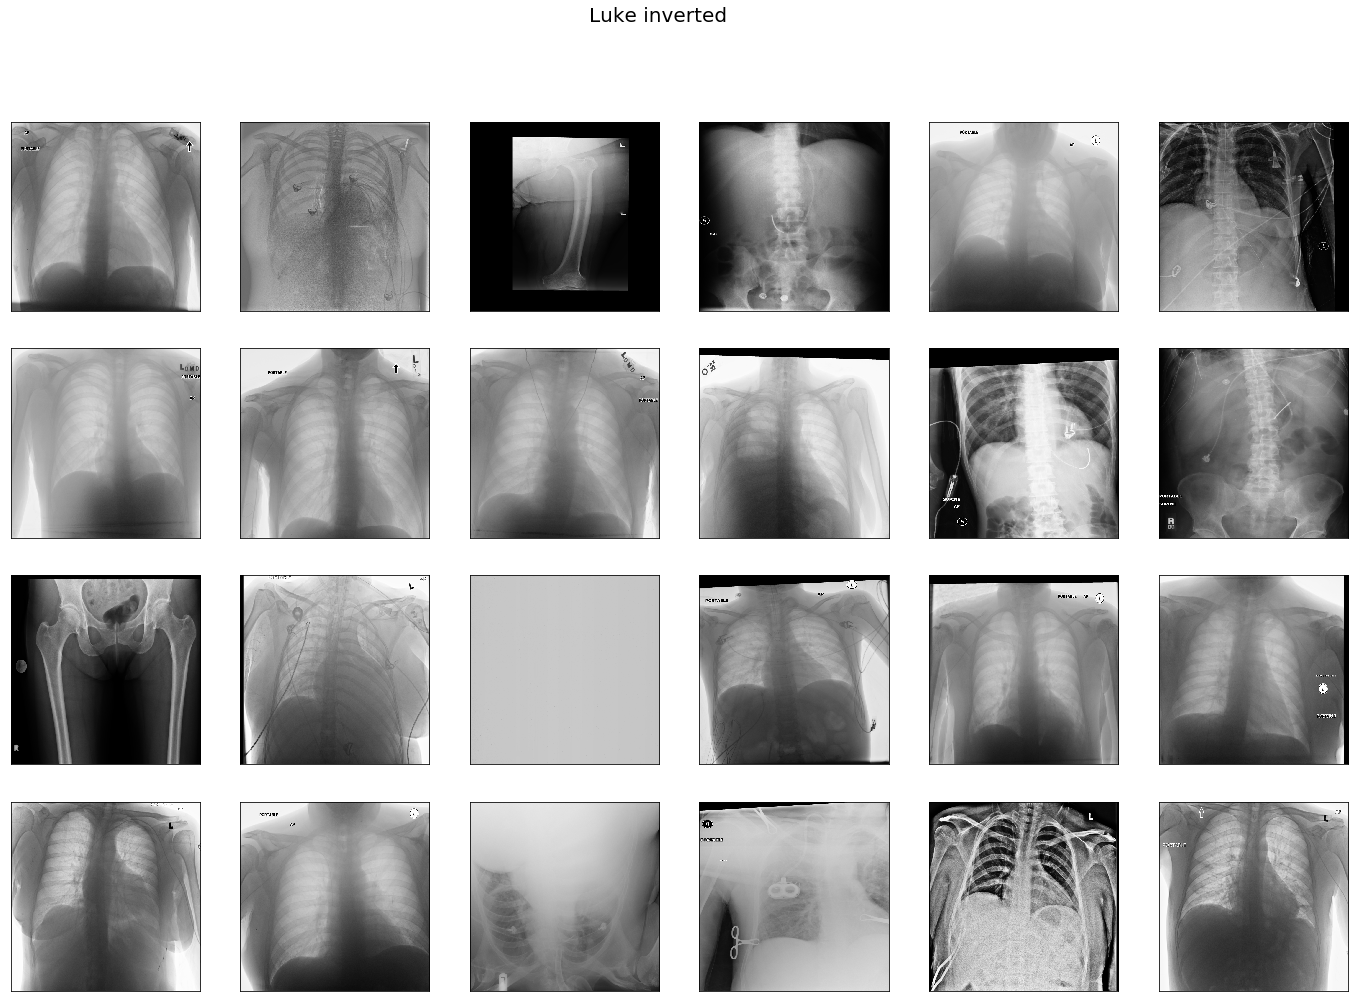

In [30]:
luke_inverted = luke_df[luke_df.Inverted == 1.0]['Index'].values
plot_batch(luke_inverted, 'Luke inverted')
luke_inverted.size

51

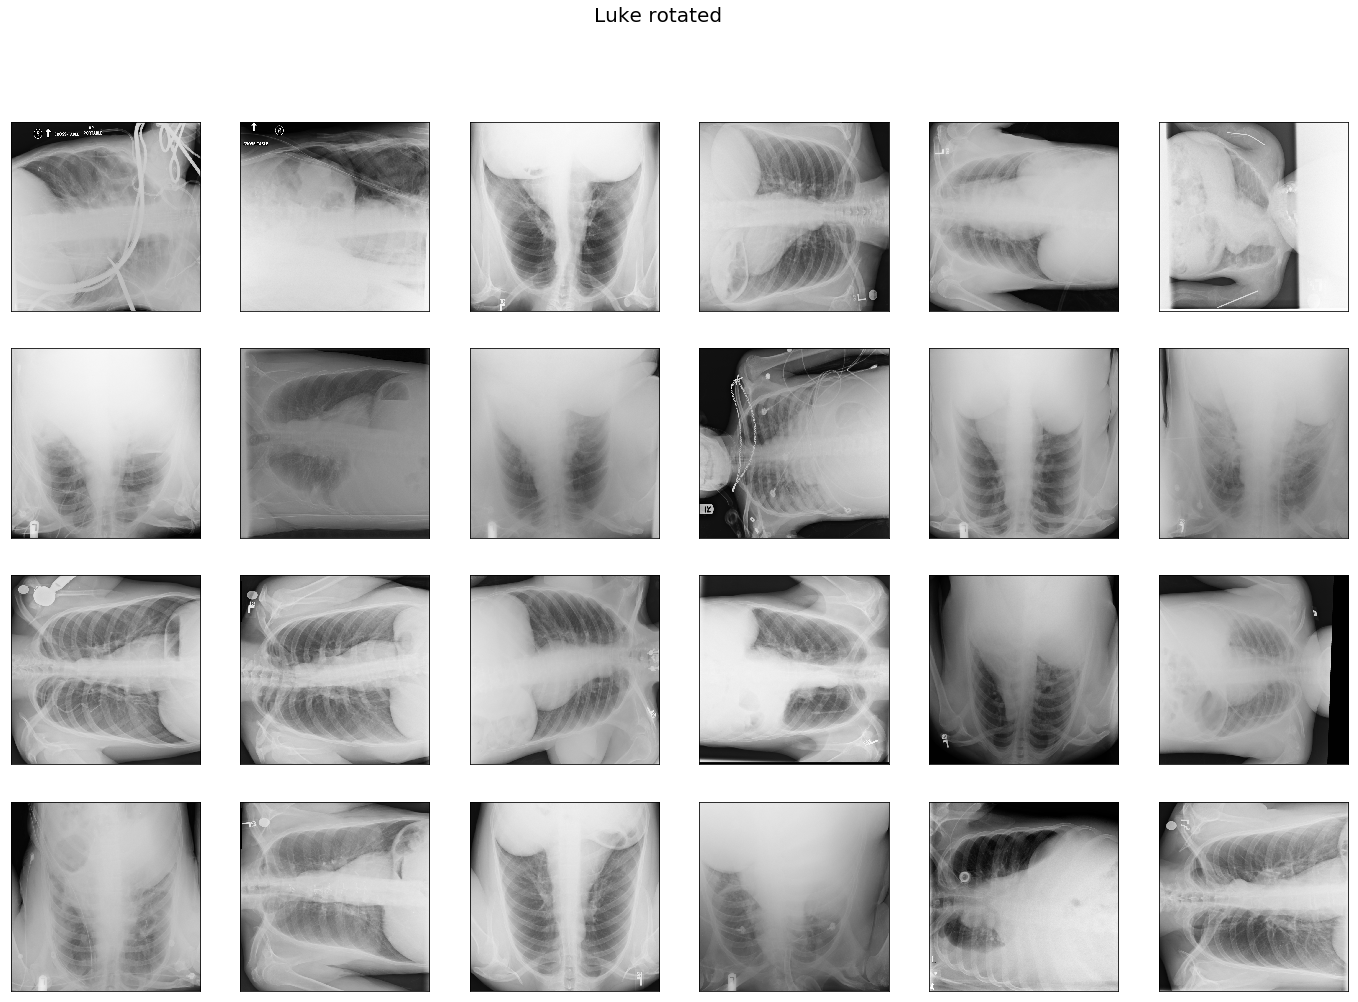

In [31]:
luke_rotated = luke_df[luke_df.Rotated == 1.0]['Index'].values
plot_batch(luke_rotated, 'Luke rotated')
luke_rotated.size

319

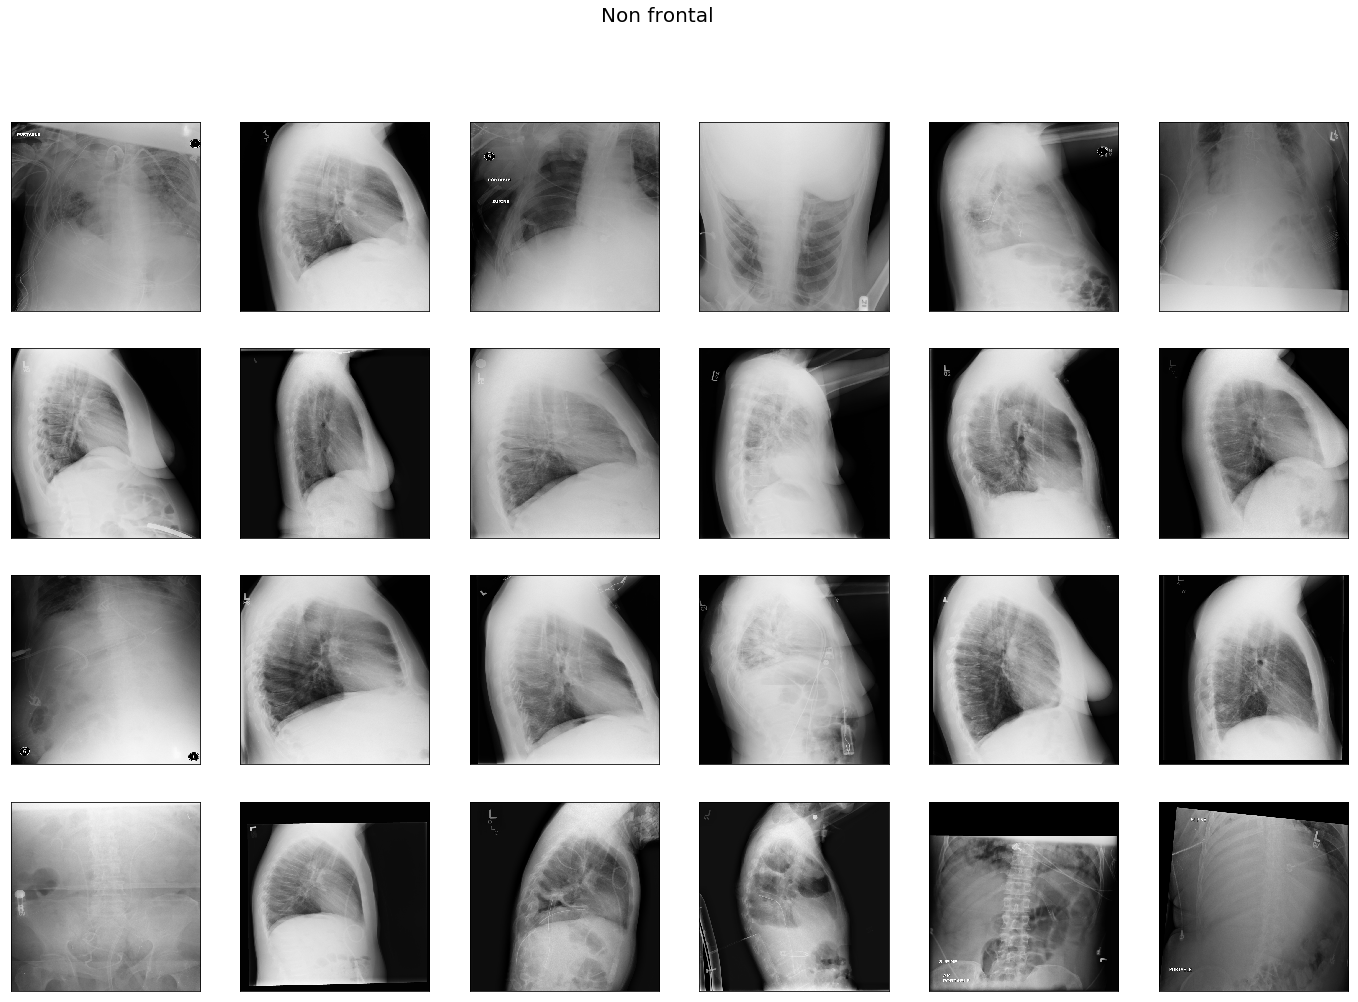

In [32]:
luke_nonPA = luke_df[luke_df['Not frontal'] == 1.0]['Index'].values
plot_batch(luke_nonPA, 'Non frontal')
luke_nonPA.size

In [35]:
image_to_excludes = set(azure_nonPA.tolist() + azure_rotated.tolist() + azure_low_quality.tolist() 
                        + luke_inverted.tolist() + luke_nonPA.tolist() + luke_rotated.tolist()
                        + age_below_10.tolist())
len(image_to_excludes)

2355

In [92]:
# def clean_chexnet(in_csv, out_csv):
#     df = pd.read_csv(in_csv, header=None, delimiter=' ')
#     should_drop = lambda x: x in image_to_excludes
#     df['Drop?'] = df.iloc[:, 0].apply(should_drop)
#     print('Origin', len(df), 'To drop', len(df[df['Drop?'] == True]))
#     df = df[df['Drop?'] == False]
#     df = df.drop('Drop?', axis=1)
#     print('Remain', len(df) )
#     print('_'*20)
#     df.to_csv(out_csv, header=None, index=False, sep=' ')
    
# print('Train')
# clean_chexnet('chexnet_train_list.csv', 'train_list.csv')
# print('Val')
# clean_chexnet('chexnet_val_list.csv', 'val_list.csv')
# print('Test')
# clean_chexnet('chexnet_test_list.csv', 'test_list.csv')

In [80]:
def clean_nih(in_csv, out_csv):
    df = pd.read_csv(in_csv, header=None, names=['image'])
    disease_df = pd.read_csv('Data_Entry_2017.csv')
    should_drop = lambda x: x in image_to_excludes
    df['Drop?'] = df.iloc[:, 0].apply(should_drop)
    print('Origin', len(df), 'To drop', len(df[df['Drop?'] == True]))
    df = df[df['Drop?'] == False]
    df = df.drop('Drop?', axis=1)
    print('Remain', len(df) )
    print('_'*20)
    df = df.merge(disease_df, how='left', left_on='image', right_on='Image Index')[['image', 'Finding Labels']]
    df.columns = ['image', 'disease']
    df.to_csv(out_csv, index=False, sep=',')
    
print('Train')
clean_nih('nih_train_val_list.csv', 'train_list.csv')
print('Test')
clean_nih('nih_test_list.csv', 'test_list.csv')

Train
Origin 86524 To drop 1826
Remain 84698
____________________
Test
Origin 25596 To drop 529
Remain 25067
____________________


In [61]:
df = pd.read_csv('Data_Entry_2017.csv')
df.head()
# disease = []
# for r in df['Finding Labels']: 
#      disease += r.split('|')
# set(disease)

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

  Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0        058Y              M            PA                 2682     2749   
1        058Y              M            PA                 2894     2729   
2        058Y              M            PA                 2500     2048   
3        081Y              M            PA                 2500     2048   
4        081Y              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                        0.143  0.143  
2                        0.168  0.168  
3                        0.171  0.171  
4                        0.143  0.143

In [82]:
df = pd.read_csv('test_list.csv')
df.head()

image              disease
0  00000003_000.png               Hernia
1  00000003_001.png               Hernia
2  00000003_002.png               Hernia
3  00000003_003.png  Hernia|Infiltration
4  00000003_004.png               Hernia